# Data Cleaning, Visualization, and Feature Engineering
In this notebook, we focus on preparing the extracted data from the previous notebook for analysis. The process includes cleaning and validating the data to handle missing values, correct inconsistencies, and remove duplicates. Following the data cleaning, we use visualization techniques to explore and understand the data, identifying patterns and insights. We then perform feature engineering to create new features and transform existing ones, such as normalizing numerical values, encoding categorical variables, and generating interaction terms. These enhancements will contribute to the development of the recommender system by providing more informative and relevant data for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
products = pd.read_csv("data/products.csv")
orders = pd.read_csv("data/orders.csv")
products_ordered = pd.read_csv("data/order-product.csv")

### Products Data Cleaning
The products are categorized into two types: main (parent) products and child products. To avoid duplicity in our data, we are consolidating the relevant information from the parent product data into the child product data. Additionally, for products that do not have associated child products, we will retain their data to ensure completeness.

In [3]:
# Seperating product list based on type
product_parent = products[products['Type']=='product']
product_child = products[products['Type']=='product_variation']
product_parent = product_parent.reset_index(drop=True)
product_child = product_child.reset_index(drop=True)

# Merge fill missing info of child product from patent product
product_child.drop(['Categories','Rating','Review Count'],axis=1,inplace=True)
product_child = pd.merge(product_child,product_parent[['ID','Categories','Rating','Review Count']], left_on='Parent Product Id', right_on='ID', how='left')
product_child.drop(['ID_y'],axis=1,inplace=True)
product_child.rename({"ID_x": "ID"},axis=1,inplace=True)

# Get products that do not have any child products
product_parent_m = pd.merge(product_parent,product_child['Parent Product Id'], how='left',left_on='ID', right_on='Parent Product Id', indicator=True)
product_parent_m = product_parent_m[product_parent_m['_merge'] == 'left_only']
product_parent_m = product_parent_m.reset_index(drop=True)
product_parent_m.drop(['Parent Product Id_y','_merge'],axis=1,inplace=True)
product_parent_m.rename({"Parent Product Id_x": "Parent Product Id"},axis=1,inplace=True)

# Merge updated child products and products without any child
final_products = pd.concat([product_child,product_parent_m])
final_products = final_products.reset_index(drop=True)

final_products.head()

,ID,Type,Parent Product Id,Status,Price,Sale Price,Sale From,Sale To,Stock Status,Size,Categories,Rating,Review Count
0,4010,product_variation,602,publish,249.0,NaN,NaN,NaN,instock,240g,27,0.0,0
1,4011,product_variation,602,publish,349.0,NaN,NaN,NaN,instock,470g,27,0.0,0
2,4013,product_variation,606,publish,249.0,NaN,NaN,NaN,instock,240g,27,5.0,1
3,4014,product_variation,606,publish,349.0,NaN,NaN,NaN,instock,470g,27,5.0,1
4,4015,product_variation,458,publish,249.0,NaN,NaN,NaN,instock,240g,"23,31",0.0,0


In [4]:
final_products[['Rating','Review Count']].value_counts()

Rating  Review Count
0.00    0               29
5.00    1                9
4.25    4                2
5.00    2                1
Name: count, dtype: int64

In [5]:
# Dropping unnecessary columns

# Parent Product ID and Type were used for merging parent and child product data; they're no longer needed.
# Ratings and Review count are currently low and won't significantly impact the recommendations. We'll revisit this feature when there's more data.
# Sale From/To dates aren't required as we're focusing on current sale prices. Checking if items are on sale is unnecessary for our analysis.

final_products.drop(['Parent Product Id', 'Type', 'Rating', 'Review Count', 'Sale From', 'Sale To'], axis=1, inplace=True)

### Products Feature Engineering
In this step, we enhance the product data by converting stock status text into a boolean field for easier analysis. We create a Final_Price column where, if a sale price is available, it is used; otherwise, the product price is applied. Additionally, we manually fill in missing values for the size column by checking the product name, description, or image, as many details have been anonymized.

In [6]:
# Changing In stock/ Out of stock to int
final_products.loc[final_products['Stock Status'] == 'instock', 'Stock Status'] = 1
final_products.loc[final_products['Stock Status'] == 'outofstock', 'Stock Status'] = 0
# Filling empty data based on field type
final_products['Sale Price'] = final_products['Sale Price'].replace(np.nan, 0)

# Adding features for whether the product is on sale / add the final price if on sale it takes sale price column else price column data
final_products["On Sale"] = (final_products['Sale Price'] != 0).astype(int)
final_products["Final Price"] = final_products['Sale Price'].where( final_products['Sale Price']!= 0, final_products['Price'])
final_products.drop(columns=['Sale Price','Price'], inplace=True)

In [7]:
# Adding values manually for products without any child products. 
# These products have only a single bottle size, which is obtained from the product description, name, or image. 
# This step ensures that the bottle size is correctly represented.

row_indexer = [22,23,24,26,28,29,30,31,32,34,35,36,40]
values = ["470g","240g","240g","240g","240g","240g","240g","240g","240g","470g","470g","470g","240g"]
final_products.loc[row_indexer, 'Size'] = values
#Few products do not have any bottle size value.
final_products['Size'] = final_products['Size'].replace(np.nan, "")
final_products.rename({"ID": "Product ID"},axis=1,inplace=True)

In [8]:
# Correcting Column Data Type
# Converting the "stock status" column from text to integer format for consistency and ease of analysis.
final_products = final_products.astype({"Stock Status": int})

In [9]:
final_products.dtypes

Product ID        int64
Status           object
Stock Status      int32
Size             object
Categories       object
On Sale           int32
Final Price     float64
dtype: object

### Products Data Visualization
In this section, we visualize key attributes of the product data to identify trends, distributions, and patterns. This includes analyzing distributions of product prices, stock status, and sizes. Visualizations will help us understand how these attributes interact and provide insights that support the development and optimization of the recommender system.

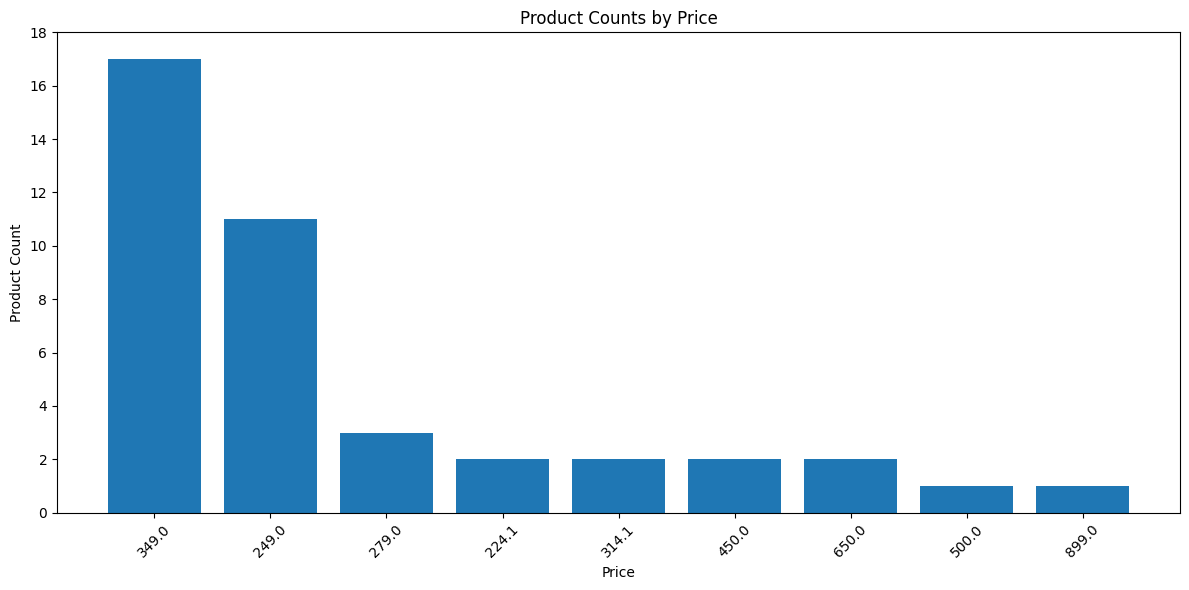

In [10]:
product_counts = final_products.groupby('Final Price').size().reset_index(name='Product Count')
product_counts = product_counts.sort_values(by='Product Count', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(range(len(product_counts)), product_counts['Product Count'])
plt.title('Product Counts by Price')
plt.xlabel('Price')
plt.ylabel('Product Count')
plt.xticks(range(len(product_counts)), product_counts['Final Price'], rotation=45)
plt.yticks(range(0,product_counts['Product Count'].max()+2, 2))
plt.tight_layout()
plt.show()

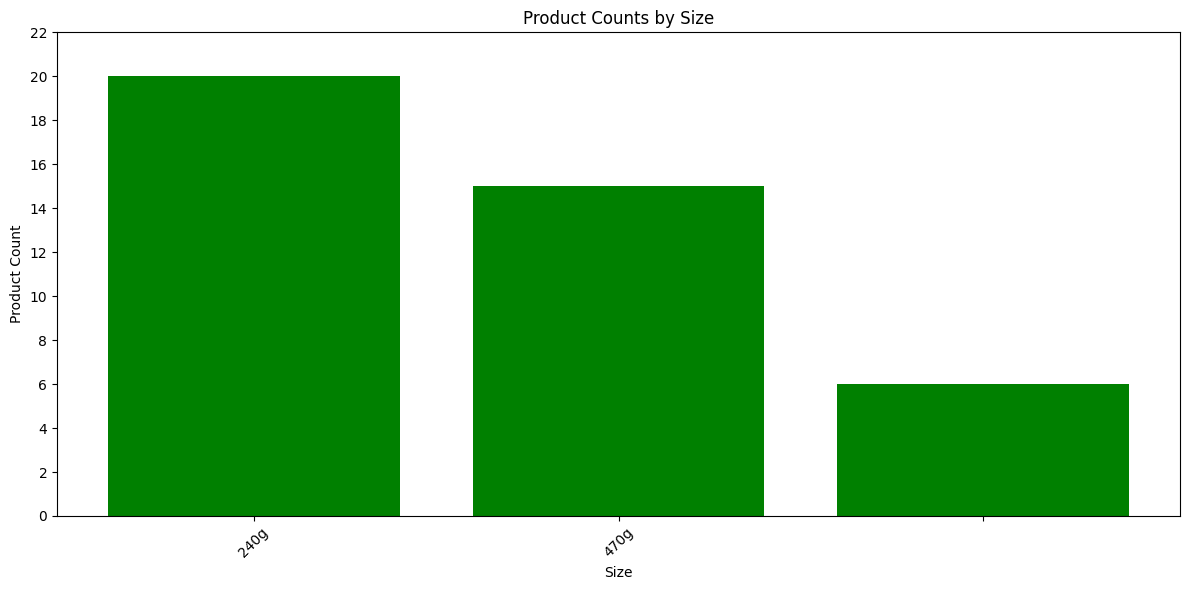

In [11]:
product_counts = final_products.groupby('Size').size().reset_index(name='Product Count')
product_counts = product_counts.sort_values(by='Product Count', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(range(len(product_counts)), product_counts['Product Count'], color='green')
plt.title('Product Counts by Size')
plt.xlabel('Size')
plt.ylabel('Product Count')
plt.xticks(range(len(product_counts)), product_counts['Size'], rotation=45)
plt.yticks(range(0,product_counts['Product Count'].max()+4, 2))
plt.tight_layout()
plt.show()

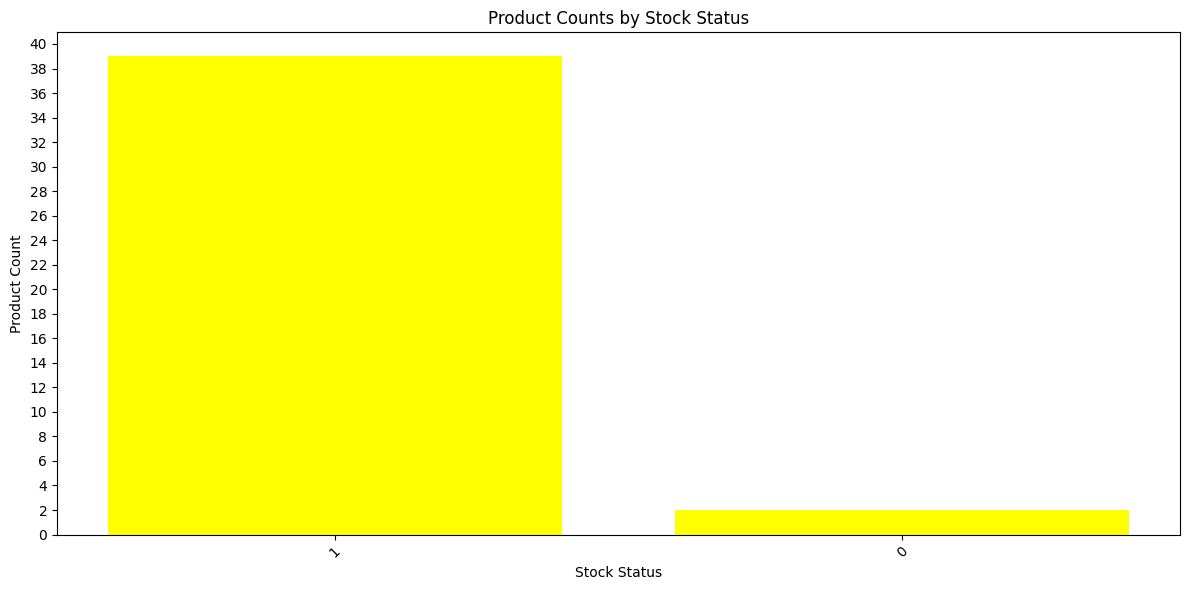

In [12]:
product_counts = final_products.groupby('Stock Status').size().reset_index(name='Product Count')
product_counts = product_counts.sort_values(by='Product Count', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(range(len(product_counts)), product_counts['Product Count'], color='yellow')
plt.title('Product Counts by Stock Status')
plt.xlabel('Stock Status')
plt.ylabel('Product Count')
plt.xticks(range(len(product_counts)), product_counts['Stock Status'], rotation=45)
plt.yticks(range(0,product_counts['Product Count'].max()+2, 2))
plt.tight_layout()
plt.show()

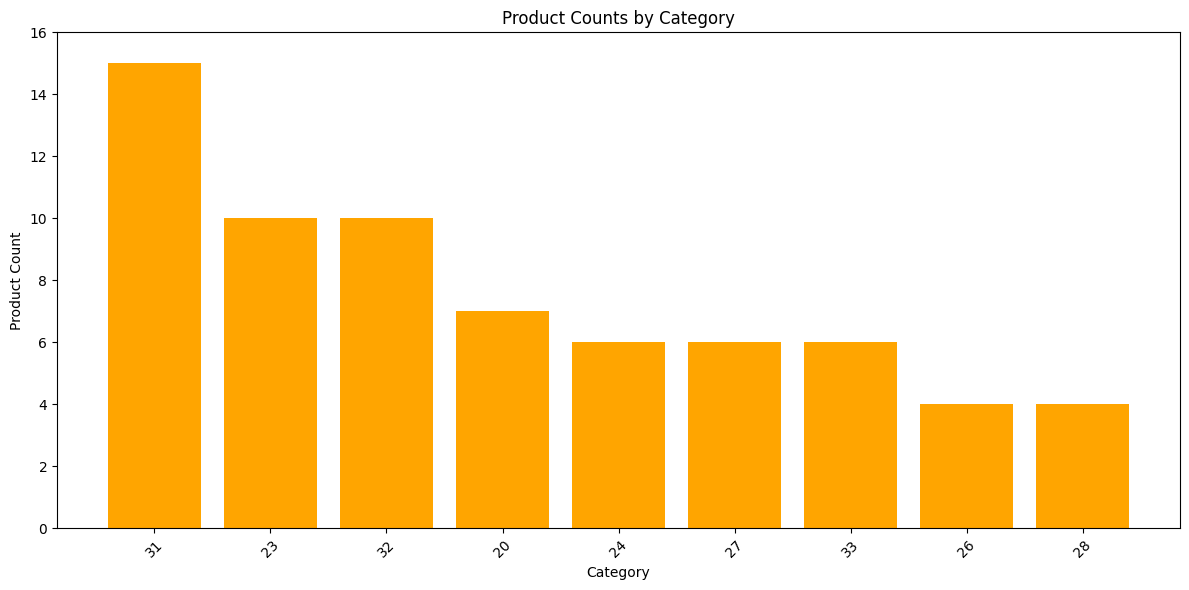

In [13]:
categories_list = final_products['Categories'].str.split(',')
flat_list = [num for sublist in categories_list for num in sublist]
flat_list = pd.DataFrame(flat_list)
flat_list.rename(columns={0:'Category'}, inplace=True)
product_counts = flat_list.groupby('Category').size().reset_index(name='Product Count')
product_counts = product_counts.sort_values(by='Product Count', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(range(len(product_counts)), product_counts['Product Count'], color='orange')
plt.title('Product Counts by Category')
plt.xlabel('Category')
plt.ylabel('Product Count')
plt.xticks(range(len(product_counts)), product_counts['Category'], rotation=45)
plt.yticks(range(0,product_counts['Product Count'].max()+2, 2))
plt.tight_layout()
plt.show()

### Orders Data Cleaning and Feature Engineering
In this section, we remove dummy orders, add a "Coupon Code Present" field and drop unnecessary columns. The order date is also transformed into separate features such as day, month, year, hour, and day of the week. These steps ensure a clean and streamlined dataset, ready for the recommender system.

In [14]:
# Removing dummy orders
# Test orders typically have small amounts (e.g., 1, 5, 10) and were placed for testing purposes only.
final_orders = orders[orders['Total Amount'] >100]

In [15]:
orders['Coupon Code ID'].value_counts()

Coupon Code ID
17019.0    64
7693.0     47
15442.0    40
5797.0     33
16207.0    27
2397.0     20
1408.0     11
15541.0    10
7602.0      8
2300.0      6
1547.0      5
2398.0      5
2029.0      4
1503.0      4
2667.0      3
20655.0     3
2575.0      2
1417.0      2
20906.0     1
14432.0     1
19748.0     1
19654.0     1
19411.0     1
8083.0      1
14428.0     1
14623.0     1
15274.0     1
8328.0      1
7731.0      1
2755.0      1
2209.0      1
19913.0     1
Name: count, dtype: int64

In [16]:
# Coupon codes are primarily used for mass marketing purposes, with very few individual coupons. 
# Let's convert the coupon field to a "Marketing Coupon" field instead.
final_orders['Coupon Code ID'] = final_orders['Coupon Code ID'].replace(np.nan, 0)
final_orders["Marketing Coupon"] = (final_orders['Coupon Code ID'] != 0).astype(int)

In [17]:
# Dropping extra columns
final_orders.drop(['Coupon Code ID'],axis=1,inplace=True)

In [18]:
final_orders['Order Date'] = pd.to_datetime(final_orders['Order Date'])
final_orders['Order Day'] = final_orders['Order Date'].dt.day
final_orders['Order Month'] = final_orders['Order Date'].dt.month
final_orders['Order Year'] = final_orders['Order Date'].dt.year
final_orders['Order Hour'] = final_orders['Order Date'].dt.hour
final_orders['Order Day of Week'] = final_orders['Order Date'].dt.dayofweek
final_orders['Order Date'] = final_orders['Order Date'].astype('int64')
final_orders['Order Date'] = final_orders['Order Date'].div(10**9)

### Orders Data Visualization
In this section, we visualize key aspects of the orders data, such as order volume over time, distribution of order amounts, and the usage of coupon codes. These visualizations help identify patterns and trends in customer purchasing behavior, providing insights that contribute to optimizing the recommender system.

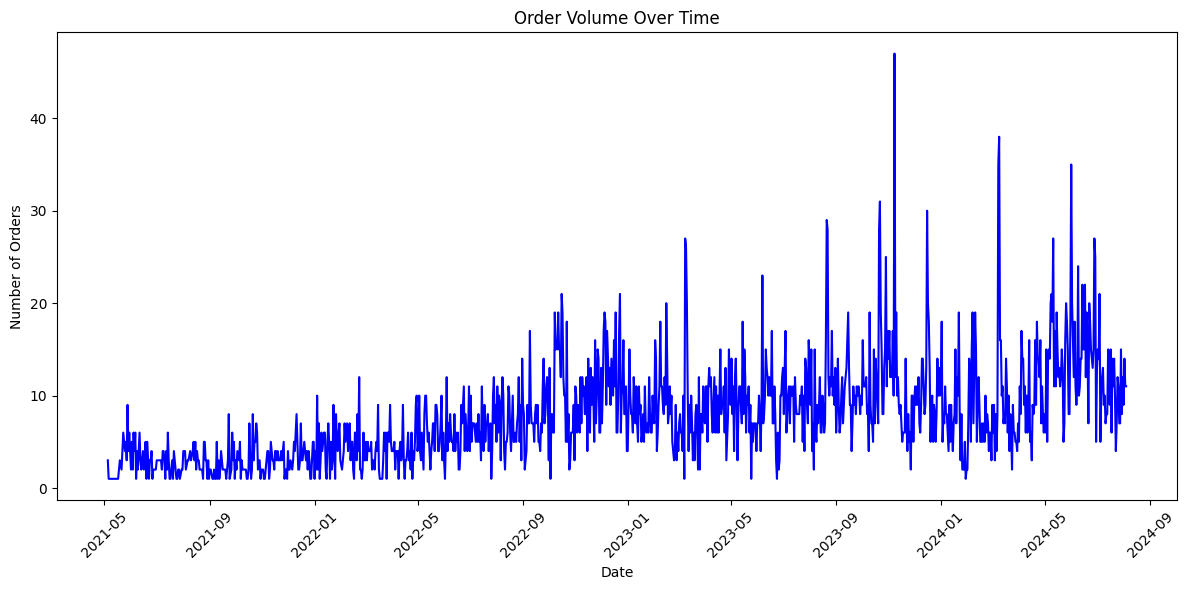

In [19]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
plt.figure(figsize=(12, 6))
orders_count = orders.groupby(orders['Order Date'].dt.date).size()
plt.plot(orders_count.index, orders_count.values, color='b')
plt.title('Order Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

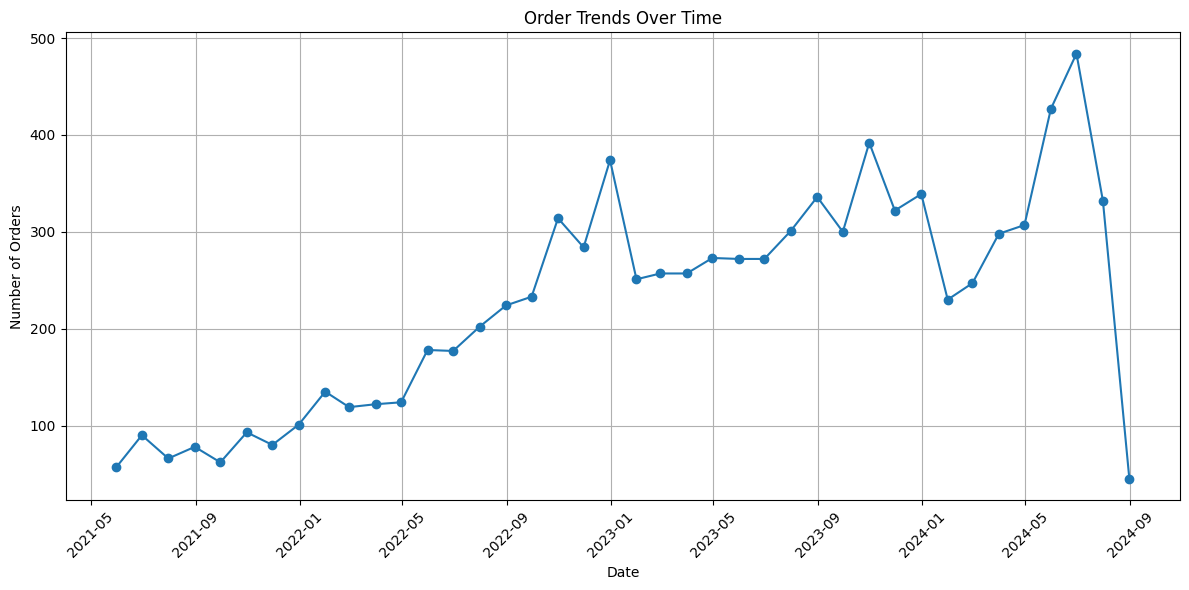

In [20]:
order_trends = orders.resample('ME', on='Order Date').agg({'ID': 'count'}).reset_index()
plt.figure(figsize=(12, 6))
plt.plot(order_trends['Order Date'], order_trends['ID'], marker='o', linestyle='-')
plt.title('Order Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

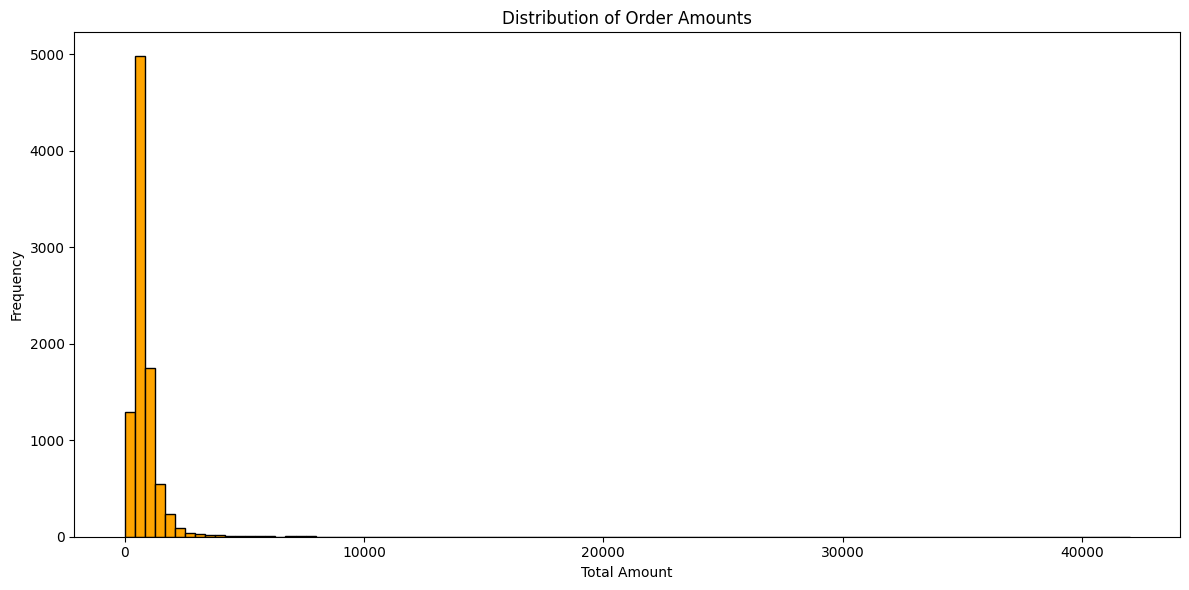

In [21]:
plt.figure(figsize=(12, 6))
plt.hist(orders['Total Amount'], bins=100, color='orange', edgecolor='black')
plt.title('Distribution of Order Amounts')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

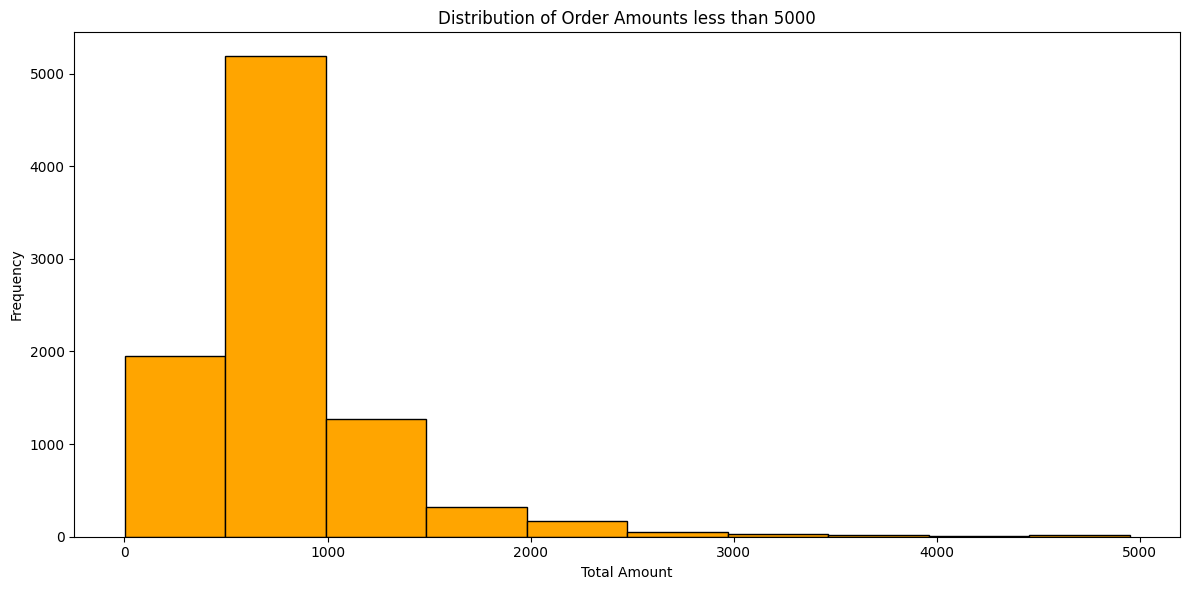

In [22]:
plt.figure(figsize=(12, 6))
plt.hist(orders[orders['Total Amount']<5000]['Total Amount'], bins=10, color='orange', edgecolor='black')
plt.title('Distribution of Order Amounts less than 5000')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

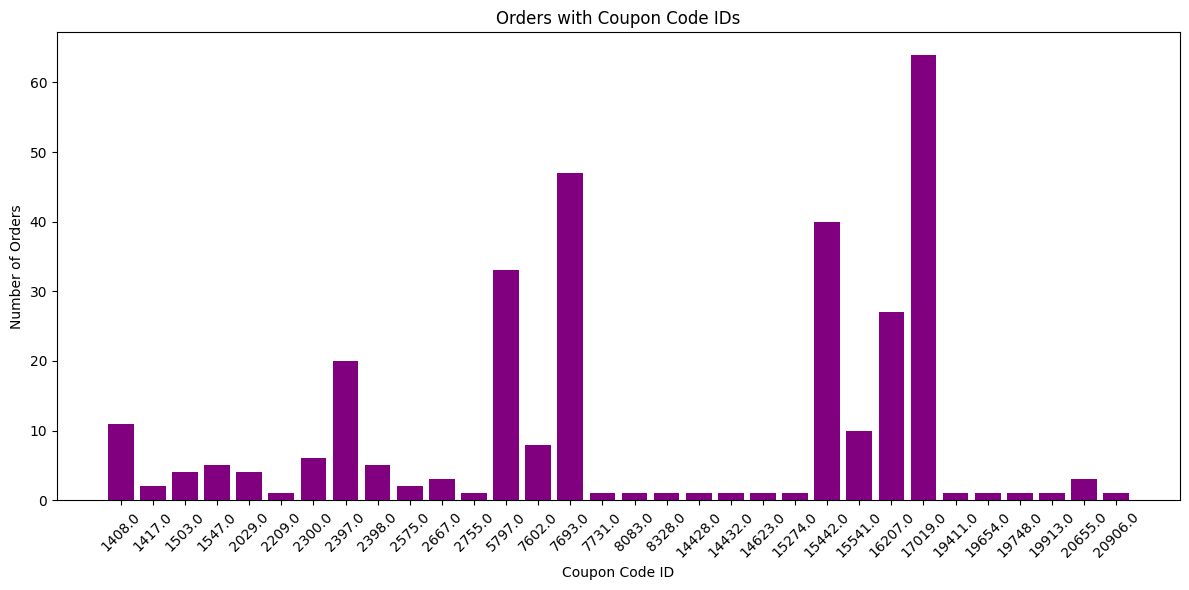

In [23]:
plt.figure(figsize=(12, 6))
orders_count = orders['Coupon Code ID'].value_counts().sort_index()
plt.bar(orders_count.index.astype(str), orders_count.values, color='purple')
plt.title('Orders with Coupon Code IDs')
plt.xlabel('Coupon Code ID')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

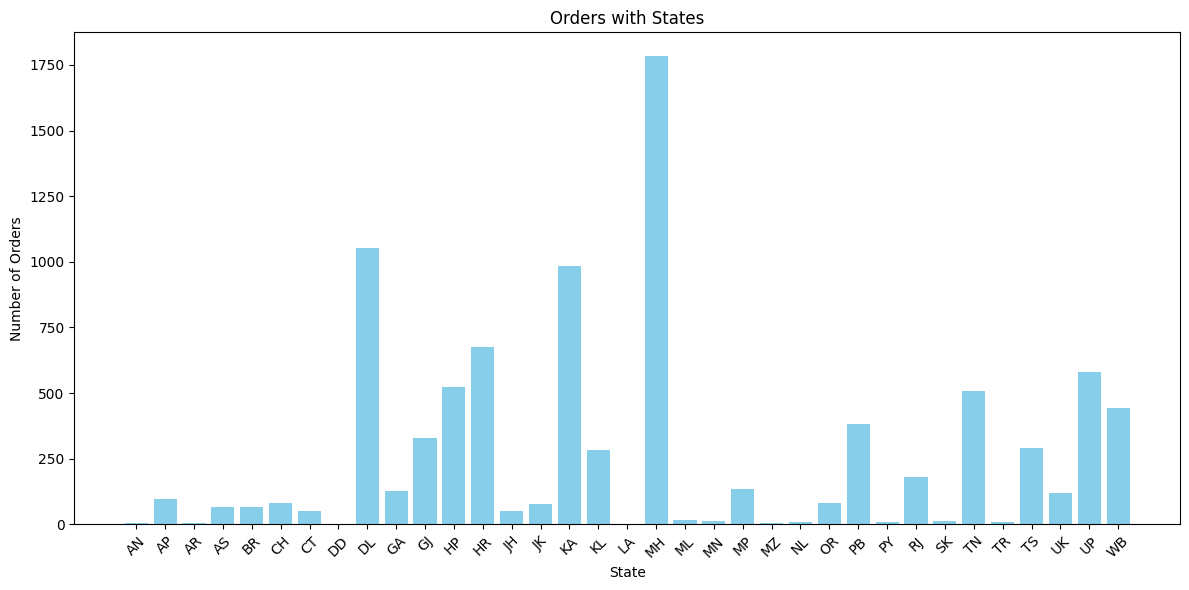

In [24]:
plt.figure(figsize=(12, 6))
orders_count = orders['Billing State'].value_counts().sort_index()
plt.bar(orders_count.index.astype(str), orders_count.values, color='skyblue')
plt.title('Orders with States')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

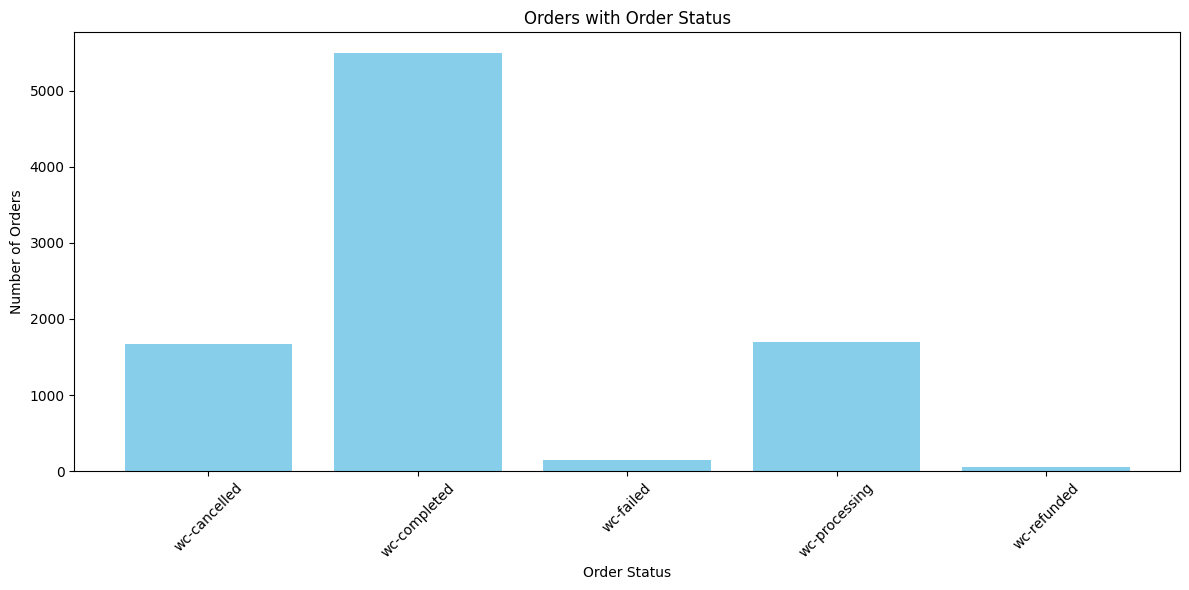

In [25]:
plt.figure(figsize=(12, 6))
orders_count = orders['Order Status'].value_counts().sort_index()
plt.bar(orders_count.index.astype(str), orders_count.values, color='skyblue')
plt.title('Orders with Order Status')
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of repeat customers: 1383
Maximum count of orders: 21


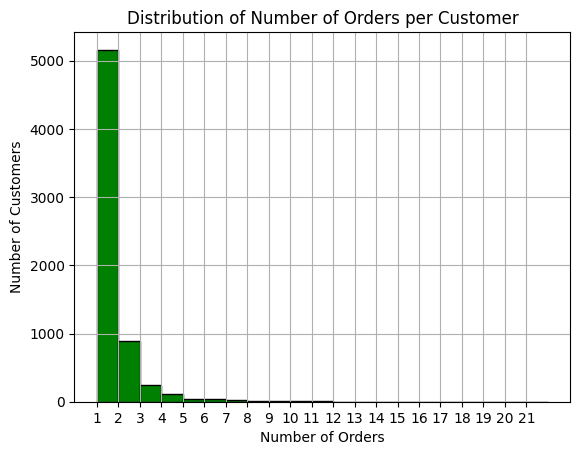

In [26]:
customer_order_counts = final_orders.groupby(['Customer Id']).size()
repeat_customers = customer_order_counts[customer_order_counts > 1]
max_order_count = customer_order_counts.max()
print("Number of repeat customers:", len(repeat_customers))
print("Maximum count of orders:", max_order_count)

plt.hist(customer_order_counts, bins=range(1, max_order_count+2), color='green', edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.title('Distribution of Number of Orders per Customer')
plt.xticks(range(1, max_order_count+1))
plt.grid(True)
plt.show()

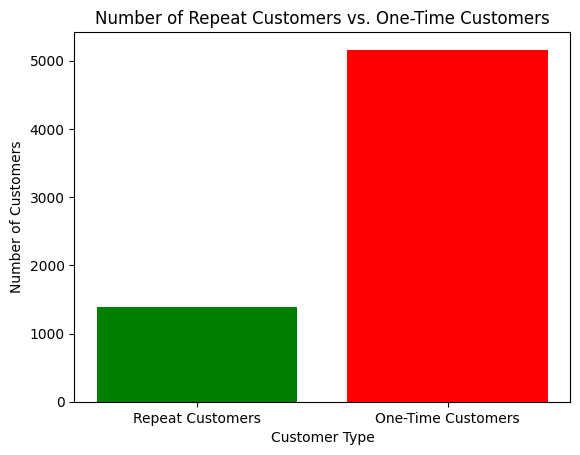

In [27]:
plt.bar(['Repeat Customers', 'One-Time Customers'], [len(repeat_customers), len(customer_order_counts) - len(repeat_customers)], color=['green', 'red'])
plt.xlabel('Customer Type')
plt.ylabel('Number of Customers')
plt.title('Number of Repeat Customers vs. One-Time Customers')
plt.show()

### Product Ordered Data Cleaning
In this section, all dummy order products were identified and removed, as these were either test entries or placeholders that did not provide meaningful insights. Additionally, many products were missing child product IDs, which were then added to maintain consistency in the data structure. Finally, category and size information from the product data was merged into the order data, ensuring that these details are readily accessible at the product level for analysis and recommendation generation.

In [28]:
# Drop dummy order products using drop orders condition
select_order_ID = orders[orders['Total Amount']>100]['ID']
final_product_ordered = products_ordered[products_ordered['Order ID'].isin(select_order_ID)]

In [29]:
# Previously, products had only a single size with no associated child products. 
# Now, we need to identify the correct child product for these single-size items  by comparing the prices at which they were sold. 
# This helps in accurately matching each product to its respective child product.

final_product_ordered.loc[final_product_ordered['Variation ID'] != 0, "Product ID"] = final_product_ordered['Variation ID']
def map_product_id(row):
    if(row['Variation ID'] == 0):
        fetch_product = products[(products['Parent Product Id'] == row['Product ID']) & (row['Total Price'] == products['Price'] )]
        if not fetch_product.empty:
            return fetch_product['ID'].iloc[0]
        fetch_product = products[(products['Parent Product Id'] == row['Product ID']) & (row['Total Price'] == products['Sale Price'] )]
        if not fetch_product.empty:
            return fetch_product['ID'].iloc[0]
        fetch_product = products[(products['Parent Product Id'] == row['Product ID']) & ((products['Price']-50 <= row['Total Price']) | (row['Total Price'] <= products['Price']))]
        if not fetch_product.empty:
            return fetch_product['ID'].iloc[0]
        fetch_product = products[(products['ID'] == row['Product ID']) & (pd.isna(products['Size']))]
        if not fetch_product.empty:
            return fetch_product['ID'].iloc[0]
    return row['Variation ID']
final_product_ordered.loc[(final_product_ordered['Variation ID'] == 0),'Variation ID'] = final_product_ordered.apply(map_product_id, axis=1)

In [30]:
# There is a single product without any size, which we identified as a dummy product created for testing purposes. 
# We are removing this product from the dataset.
final_product_ordered = final_product_ordered[final_product_ordered['Variation ID']!=0]

In [31]:
# Dropping extra columns
final_product_ordered.drop(columns=['Product ID'], inplace=True)
final_product_ordered.rename(columns={'Variation ID': 'Product ID'},  inplace=True)

# Merging product data to include additional information such as category and size. 
# This helps in consolidating and enriching the dataset to provide a more comprehensive view of each product.
final_product_ordered = pd.merge(final_product_ordered, final_products[['Product ID','Categories','Size']], on='Product ID', how='left')

In [32]:
# Identify on-sale products by checking if the main price of the product matches the purchase price recorded in the order.

final_product_ordered['On Sale'] = 0
on_sale_check = pd.merge(final_product_ordered[['Product ID', 'Total Price']], products[['ID','Price']], left_on='Product ID', right_on='ID', how='left')
final_product_ordered["On Sale"] = (on_sale_check['Price'] == on_sale_check['Total Price']).astype(int)

### Product Ordered Data Visualizations
This section visualizes key metrics related to product orders, including the top 10 products by order volume, the distribution of ordered products across different categories, and a monthly analysis of the top 10 products to observe trends and seasonal variations.

In [33]:
# Found 14 duplicate products deleting those
final_product_ordered.drop_duplicates(subset=['Order ID', 'Product ID'], keep='first', inplace=True)

Top Products by Order Count:
  Product ID  Order ID  Total Price
3       1707      2488    1016718.0
1        610      1422     425652.0
0        499      1386     467046.0
4       1958      1073     291191.0
2        615      1002     300200.0


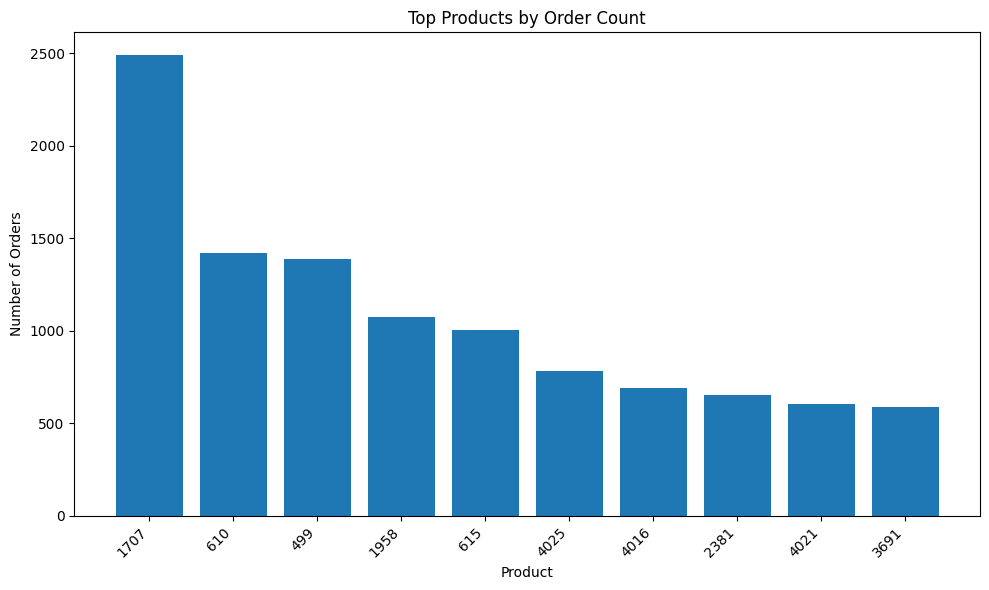

In [34]:
product_analysis = final_product_ordered.groupby('Product ID').agg({'Order ID': 'count', 'Total Price': 'sum'}).reset_index()

# Sort by order count or total amount, depending on your preference
product_analysis_sorted = product_analysis.sort_values(by='Order ID', ascending=False)
product_analysis_sorted['Product ID'] = product_analysis_sorted['Product ID'].astype('str')

# Print top products by order count
print("Top Products by Order Count:")
print(product_analysis_sorted.head())
# Create a bar plot for top products by order count
plt.figure(figsize=(10, 6))
plt.bar(product_analysis_sorted['Product ID'][:10], product_analysis_sorted['Order ID'][:10])
plt.title('Top Products by Order Count')
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

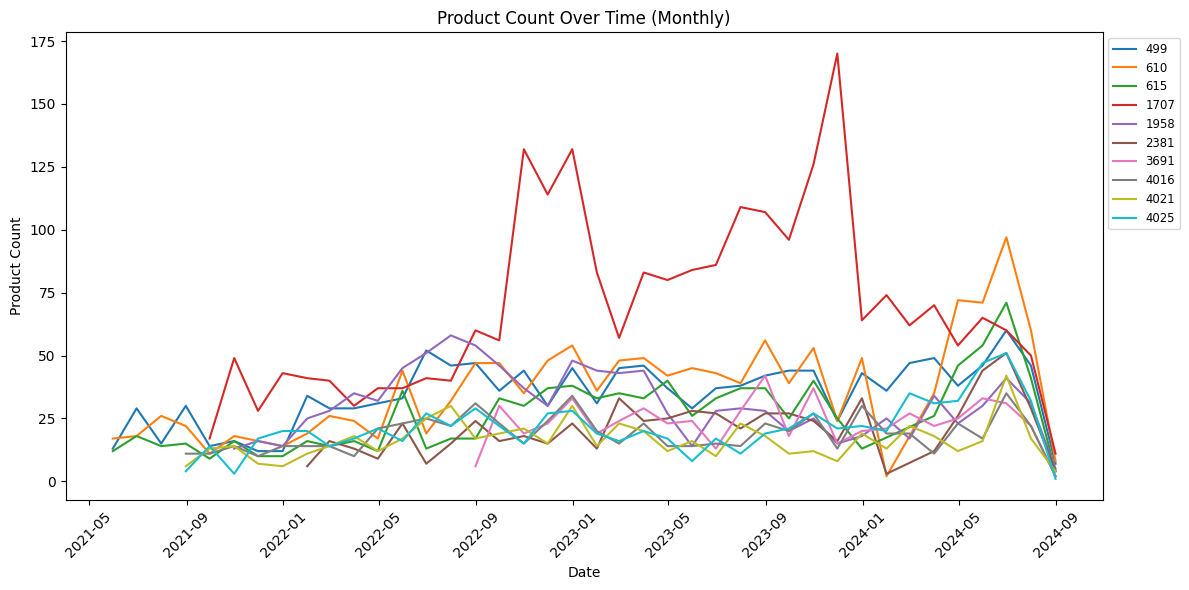

In [35]:
top_10_products = product_analysis_sorted[:10]['Product ID']
top_10_orders = pd.merge(final_product_ordered, orders[['ID', 'Order Date']], left_on='Order ID',right_on='ID')
top_10_products = top_10_products.astype('int')
product_analysis_sorted['Product ID'] = product_analysis_sorted['Product ID'].astype('int')
top_10_orders = top_10_orders[top_10_orders['Product ID'].isin(top_10_products)]
product_count_monthly = top_10_orders.groupby(['Product ID', pd.Grouper(key='Order Date', freq='ME')]).size().reset_index(name='Product Count')

# Merge product names with analysis results
product_names = final_products[['Product ID']].drop_duplicates()

# Plot product count over time
plt.figure(figsize=(12, 6))
for product_id, product_group in product_count_monthly.groupby('Product ID'):
    plt.plot(product_group['Order Date'], product_group['Product Count'], label=product_group['Product ID'].iloc[0])

plt.title('Product Count Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Product Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

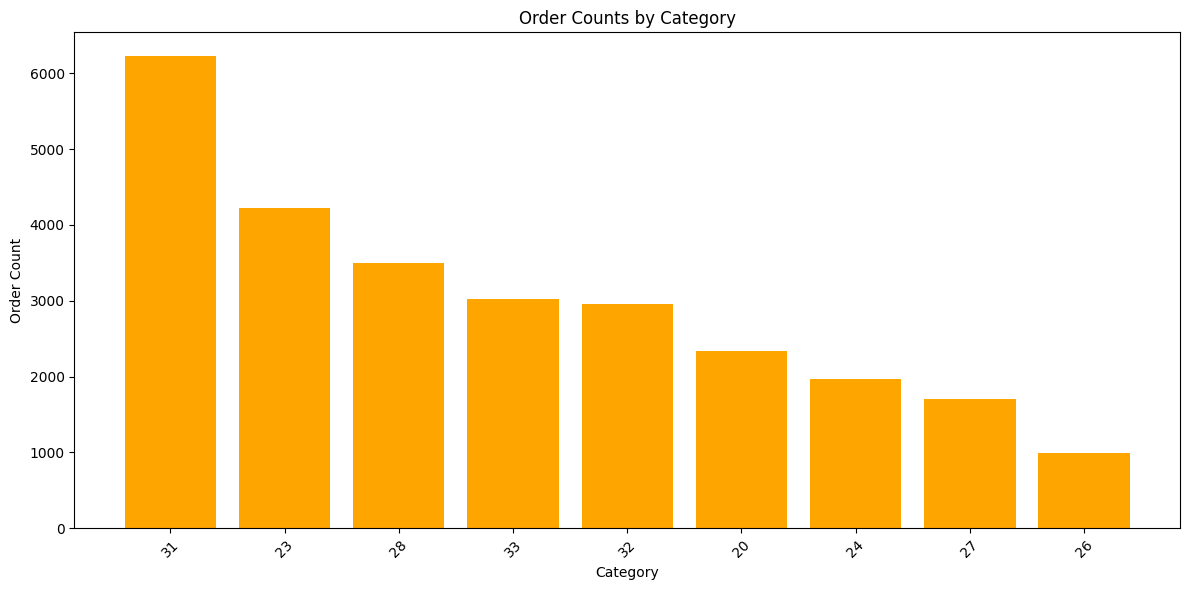

In [36]:
categories_list = final_product_ordered['Categories'].str.split(',')
flat_list = [num for sublist in categories_list for num in sublist]
flat_list = pd.DataFrame(flat_list)
flat_list.rename(columns={0:'Category'}, inplace=True)
product_counts = flat_list.groupby('Category').size().reset_index(name='Order Count')
product_counts = product_counts.sort_values(by='Order Count', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(range(len(product_counts)), product_counts['Order Count'], color='orange')
plt.title('Order Counts by Category')
plt.xlabel('Category')
plt.ylabel('Order Count')
plt.xticks(range(len(product_counts)), product_counts['Category'], rotation=45)
plt.tight_layout()
plt.show()

### User-Item Matrix
In this step, we will create a user-item matrix from the order data. The matrix will represent whether a product has been purchased by a user (indicated by a 1) or not (indicated by a 0). This matrix will serve as the foundation for collaborative filtering, enabling us to recommend products based on user behavior and preferences.

In [37]:
user_list = pd.DataFrame(list(set(final_orders['Customer Id'])))
user_list.rename(columns={0: 'User ID'}, inplace=True)
product_list = pd.DataFrame(list(set(final_products['Product ID'])))
product_list.rename(columns={0: 'Product ID'}, inplace=True)

cross_join = pd.merge(product_list.assign(key=1), user_list.assign(key=1), on='key').drop('key', axis=1)
order_data = pd.merge(orders[['ID', 'Customer Id']], products_ordered[['Order ID', 'Product ID', 'QTY']], left_on='ID', right_on='Order ID').drop(['ID','Order ID'], axis=1)
order_data.rename(columns={'Customer Id': 'User ID'}, inplace=True)
product_count = order_data.groupby(['User ID', 'Product ID'])['QTY'].sum().reset_index(name='Product Count')
user_product_data = pd.merge(cross_join, product_count, on=['User ID', 'Product ID'], how='left')
user_product_data['Product Count'].fillna(0, inplace=True)
user_product_data['Log Product Count'] = user_product_data['Product Count'].apply(lambda x: np.log(x + 1)) 
user_product_data['Product Bought'] = user_product_data['Product Count'].apply(lambda x: 1 if x > 0 else 0) 

user_item_matrix = user_product_data.pivot_table(index='User ID', columns='Product ID', values='Product Bought', fill_value=0)

In [38]:
# Save all updated dataframes so they are accessible for the next notebook.
final_products.to_csv("data/final-products.csv", index=False)
final_product_ordered.to_csv("data/final-product-ordered.csv", index=False)
final_orders.to_csv("data/final-orders.csv", index=False)
user_product_data.to_csv('data/user-product-data.csv', index=False)
user_item_matrix.to_csv('data/user-item-matrix.csv', index=True)

### Conclusion
In this notebook, we conducted a comprehensive analysis of product and order data, featuring detailed visualizations of product performance, order volumes, and category distribution. By examining the top products, category counts, and monthly trends, we have gained valuable insights into product popularity and ordering patterns. These insights will be instrumental in refining the recommender system to better reflect user preferences and enhance the overall customer experience.

### Next Step
The next step is to create and train the recommender system model using these insights.